In [108]:
import json
import numpy as np
import time
import matplotlib.pyplot as plt

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, Input
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.datasets import to_forecasting
from reservoirpy.datasets import doublescroll
from reservoirpy.hyper import research

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

In [2]:
loaded_dataset = np.load("./out/pca_features_20000.npz")

X_dataset = loaded_dataset["X_dataset"]
Y_dataset = loaded_dataset["Y_dataset"]

print(X_dataset.shape)
print(Y_dataset.shape)

(20000, 200, 53)
(20000,)


In [3]:
np.sum(Y_dataset == 1)

10000

In [4]:
real_videos = X_dataset[Y_dataset[0] == 0]  # Videos with target 0
fake_videos = X_dataset[Y_dataset[0] == 1]  # Videos with target 1

# Calculate the mean EAR and Δ EAR for real and fake videos
mean_ear_real = np.mean(real_videos[:, :, 0], axis=0)  # Assuming EAR is feature 0
mean_delta_ear_real = np.mean(real_videos[:, :, 1], axis=0)  # Assuming Δ EAR is feature 1

mean_ear_fake = np.mean(fake_videos[:, :, 0], axis=0)

mean_delta_ear_fake = np.mean(fake_videos[:, :, 1], axis=0)

/Users/mughalfrazk/Study/SHU/Dissertation/code/deepfake-detection-using-esn/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mughalfrazk/Study/SHU/Dissertation/code/deepfake-detection-using-esn/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


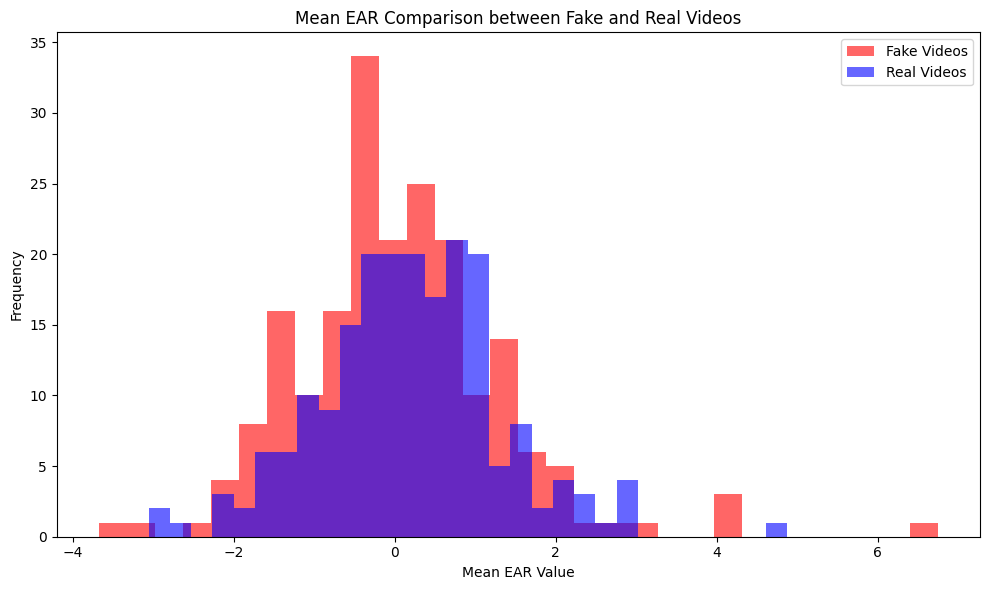

In [6]:
# Extract just the EAR feature (first feature in each frame)
ear_data = X_dataset[:, :, 0]
mean_ear = np.mean(ear_data, axis=1) 

# Split the data into fake and real videos based on the labels
mean_fake_ear = mean_ear[Y_dataset == 0]  # Mean EAR for fake videos
mean_real_ear = mean_ear[Y_dataset == 1]  # Mean EAR for real videos

# Plot the mean EAR values for fake and real videos
plt.figure(figsize=(10, 6))

# Plot the mean EAR for fake videos
plt.hist(mean_fake_ear[800:1000], bins=30, alpha=0.6, label='Fake Videos', color='red')

# Plot the mean EAR for real videos
plt.hist(mean_real_ear[1000:1200], bins=30, alpha=0.6, label='Real Videos', color='blue')

# Add title and labels
plt.title('Mean EAR Comparison between Fake and Real Videos')
plt.xlabel('Mean EAR Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

/var/folders/7t/tn7d7_7x0294gvz7svhdqz480000gn/T/ipykernel_55129/2099267004.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_fake_ear[5000:5200], mean_real_ear[5200:5400]],


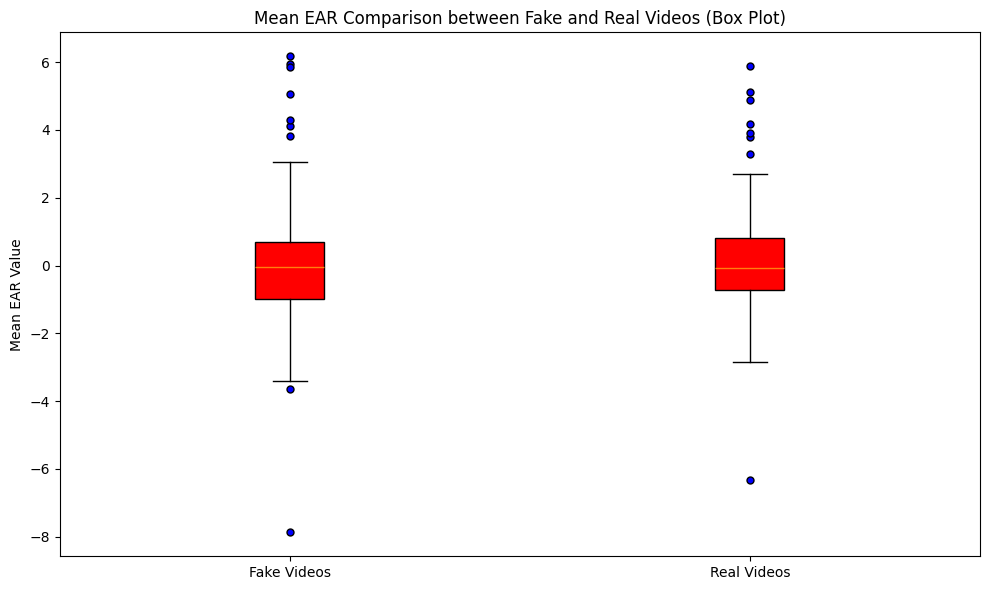

In [8]:
# Extract just the EAR feature (first feature in each frame)
ear_data = X_dataset[:, :, 0]
mean_ear = np.mean(ear_data, axis=1) 

# Split the data into fake and real videos based on the labels
mean_fake_ear = mean_ear[Y_dataset == 0]  # Mean EAR for fake videos
mean_real_ear = mean_ear[Y_dataset == 1]  # Mean EAR for real videos

# Create a box plot for the mean EAR values
plt.figure(figsize=(10, 6))

# Plot the data: each box corresponds to either fake or real videos
plt.boxplot([mean_fake_ear[5000:5200], mean_real_ear[5200:5400]], 
            labels=['Fake Videos', 'Real Videos'], 
            patch_artist=True, 
            boxprops=dict(facecolor='red', color='black'),  # Red for fake
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='blue', marker='o', markersize=5))  # Blue for outliers

# Add title and labels
plt.title('Mean EAR Comparison between Fake and Real Videos (Box Plot)')
plt.ylabel('Mean EAR Value')
plt.tight_layout()
plt.show()

In [9]:
# Flatten the data (3748, 1814, 53) -> (3748, 1814 * 53)
X_flat = X_dataset.reshape(X_dataset.shape[0], -1)

scalar = StandardScaler()
X_flat = scalar.fit_transform(X_flat)

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y_dataset, test_size=0.2, random_state=12)

In [10]:
# Reshape target labels to 2D array (required by ReservoirPy Ridge)
y_train = y_train.reshape(-1, 1)  # Shape (n_samples, 1)
y_test =  y_test.reshape(-1, 1)    # Shape (n_samples, 1)

In [11]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (16000, 10600)
y_train:  (16000, 1)


## Training comparison with hyperparameter tuning

### Selected Hyperparameters

- Leak Rate = 1
- Spectral Radius = 1.25
- Input Scaling = 1.0

In [99]:
UNITS = 3000              # - number of neurons
LEAK_RATE = 1             # - leaking rate
SPECTRAL_RADIUS = 1.25    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [100]:
# data = Input(input_dim=X_train.shape[1])
# reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
# ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

# esn = data >> reservoir >> ridge

# esn.fit(X_train, y_train)

# # Make predictions & binarize it
# predictions = esn.run(X_test)
# predicted_labels = (predictions.flatten() > 0.5).astype(int)

# # Evaluate the model
# accuracy = np.mean(predicted_labels == y_test.flatten())
# print(f"Model accuracy on test set: {accuracy:.4f}")

In [109]:
reservoir_sizes = [500, 1000, 2000, 3000, 4000]

# Containers to store results
accuracy_results = []
f1_results = []
training_times = []

# Loop through different reservoir sizes
for UNITS in reservoir_sizes:
    start_time = time.time()
    
    # Initialize ESN model with varying reservoir size
    data = Input(input_dim=X_train.shape[1])
    reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
    ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

    esn = data >> reservoir >> ridge

    # Train the ESN
    esn.fit(X_train, y_train)

    # Predict on test data
    predictions = esn.run(X_test)
    predicted_labels = (predictions.flatten() > 0.5).astype(int)

    # Evaluate performance
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    # Record results
    accuracy_results.append(acc)
    f1_results.append(f1)
    training_times.append(time.time() - start_time)

    print(f"Reservoir Size: {UNITS} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | Training Time: {training_times[-1]:.2f}s")


Running Model-35: 16000it [00:11, 1407.70it/s]?, ?it/s]
Running Model-35: 100%|██████████| 1/1 [00:11<00:00, 11.44s/it]


Fitting node Ridge-17...


Running Model-35: 4000it [00:02, 1424.96it/s]          


Reservoir Size: 500 | Accuracy: 0.5655 | F1-Score: 0.5611 | Training Time: 14.54s


Running Model-37: 16000it [00:21, 728.86it/s]<?, ?it/s]
Running Model-37: 100%|██████████| 1/1 [00:22<00:00, 22.17s/it]


Fitting node Ridge-18...


Running Model-37: 4000it [00:05, 735.64it/s]           


Reservoir Size: 1000 | Accuracy: 0.5797 | F1-Score: 0.5830 | Training Time: 28.20s


Running Model-39: 16000it [00:47, 336.87it/s]<?, ?it/s]
Running Model-39: 100%|██████████| 1/1 [00:48<00:00, 48.36s/it]


Fitting node Ridge-19...


Running Model-39: 4000it [00:11, 344.98it/s]           


Reservoir Size: 2000 | Accuracy: 0.5995 | F1-Score: 0.6044 | Training Time: 63.03s


Running Model-41: 16000it [01:15, 212.50it/s]<?, ?it/s]
Running Model-41: 100%|██████████| 1/1 [01:16<00:00, 76.72s/it]


Fitting node Ridge-20...


Running Model-41: 4000it [00:18, 214.89it/s]           


Reservoir Size: 3000 | Accuracy: 0.6462 | F1-Score: 0.6598 | Training Time: 98.08s


Running Model-43: 16000it [01:47, 148.37it/s]<?, ?it/s]
Running Model-43: 100%|██████████| 1/1 [01:50<00:00, 110.41s/it]


Fitting node Ridge-21...


Running Model-43: 4000it [00:26, 149.87it/s]           

Reservoir Size: 4000 | Accuracy: 0.6570 | F1-Score: 0.6733 | Training Time: 144.61s


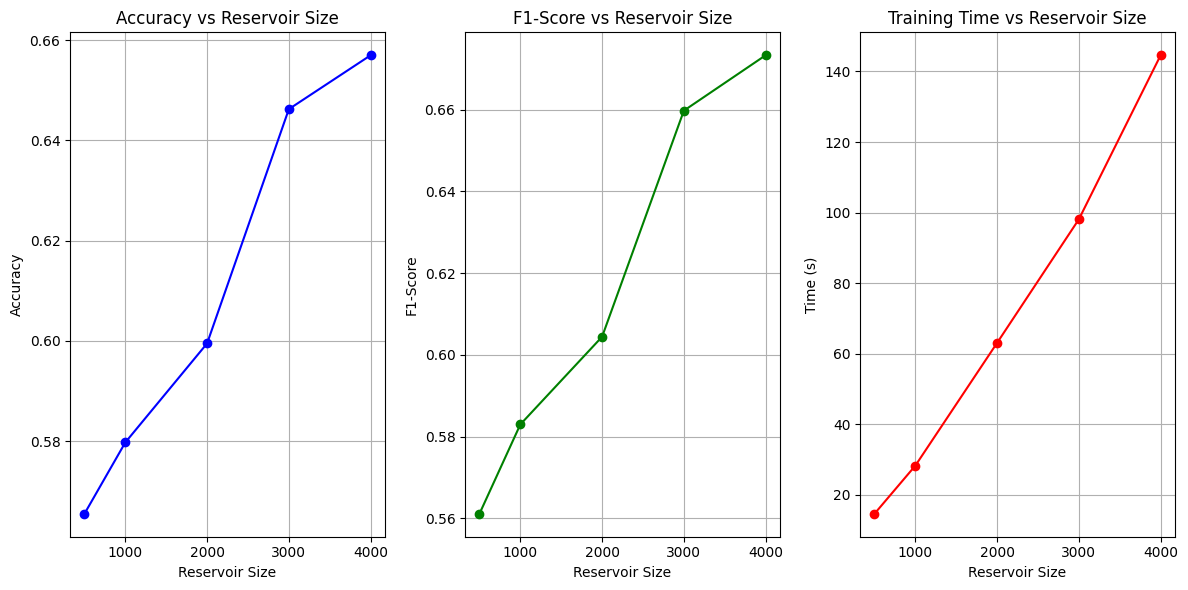

In [110]:

# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(reservoir_sizes, accuracy_results, marker='o', color='blue')
plt.title("Accuracy vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Accuracy")
plt.grid(True)

# F1-Score Plot
plt.subplot(1, 3, 2)
plt.plot(reservoir_sizes, f1_results, marker='o', color='green')
plt.title("F1-Score vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("F1-Score")
plt.grid(True)

# Training Time Plot
plt.subplot(1, 3, 3)
plt.plot(reservoir_sizes, training_times, marker='o', color='red')
plt.title("Training Time vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

### Selected Hyperparameters

- Leak Rate = 0.3
- Spectral Radius = 1.25
- Input Scaling = 1.0

In [111]:
LEAK_RATE = 0.3             # - leaking rate
SPECTRAL_RADIUS = 1.25    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [112]:
reservoir_sizes = [500, 1000, 2000, 3000, 4000]

# Containers to store results
accuracy_results = []
f1_results = []
training_times = []

# Loop through different reservoir sizes
for UNITS in reservoir_sizes:
    start_time = time.time()
    
    # Initialize ESN model with varying reservoir size
    data = Input(input_dim=X_train.shape[1])
    reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
    ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

    esn = data >> reservoir >> ridge

    # Train the ESN
    esn.fit(X_train, y_train)

    # Predict on test data
    predictions = esn.run(X_test)
    predicted_labels = (predictions.flatten() > 0.5).astype(int)

    # Evaluate performance
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    # Record results
    accuracy_results.append(acc)
    f1_results.append(f1)
    training_times.append(time.time() - start_time)

    print(f"Reservoir Size: {UNITS} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | Training Time: {training_times[-1]:.2f}s")


Running Model-45: 16000it [00:11, 1433.71it/s]?, ?it/s]
Running Model-45: 100%|██████████| 1/1 [00:11<00:00, 11.23s/it]


Fitting node Ridge-22...


Running Model-45: 4000it [00:02, 1440.29it/s]          


Reservoir Size: 500 | Accuracy: 0.5270 | F1-Score: 0.5166 | Training Time: 14.37s


Running Model-47: 16000it [00:22, 724.96it/s]<?, ?it/s]
Running Model-47: 100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


Fitting node Ridge-23...


Running Model-47: 4000it [00:05, 718.97it/s]           


Reservoir Size: 1000 | Accuracy: 0.5467 | F1-Score: 0.5355 | Training Time: 28.50s


Running Model-49: 16000it [00:46, 344.12it/s]<?, ?it/s]
Running Model-49: 100%|██████████| 1/1 [00:47<00:00, 47.16s/it]


Fitting node Ridge-24...


Running Model-49: 4000it [00:11, 348.95it/s]           


Reservoir Size: 2000 | Accuracy: 0.5650 | F1-Score: 0.5714 | Training Time: 60.06s


Running Model-51: 16000it [01:15, 212.62it/s]<?, ?it/s]
Running Model-51: 100%|██████████| 1/1 [01:16<00:00, 76.76s/it]


Fitting node Ridge-25...


Running Model-51: 4000it [00:18, 213.92it/s]           


Reservoir Size: 3000 | Accuracy: 0.5770 | F1-Score: 0.5787 | Training Time: 97.75s


Running Model-53: 16000it [01:47, 148.99it/s]<?, ?it/s]
Running Model-53: 100%|██████████| 1/1 [01:49<00:00, 109.69s/it]


Fitting node Ridge-26...


Running Model-53: 4000it [00:26, 150.11it/s]           

Reservoir Size: 4000 | Accuracy: 0.5700 | F1-Score: 0.5851 | Training Time: 148.93s


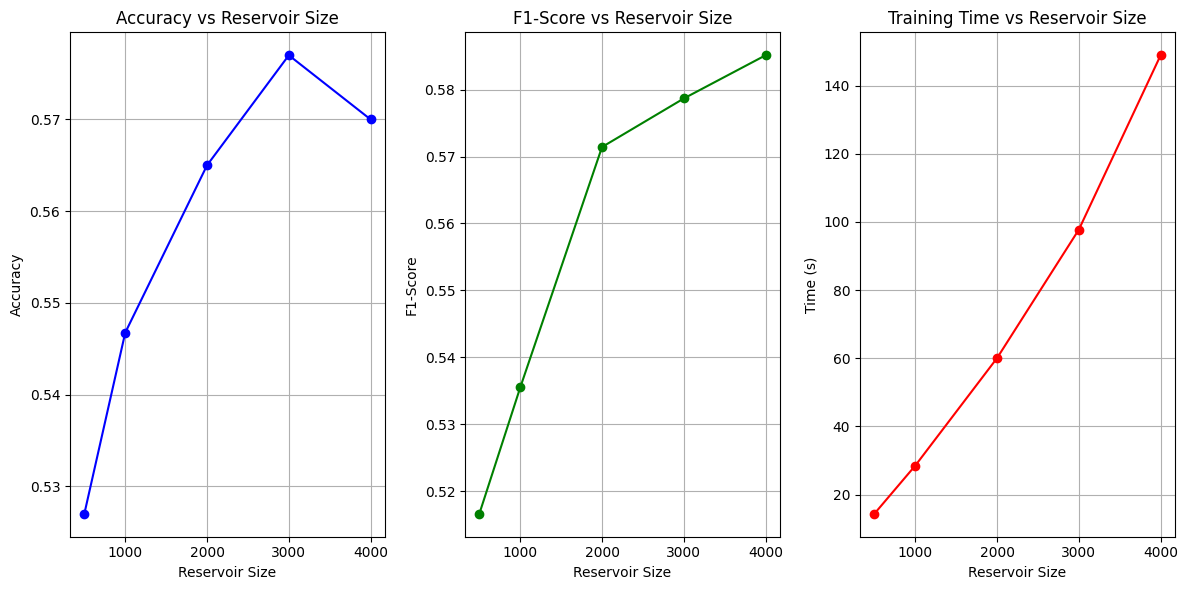

In [113]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(reservoir_sizes, accuracy_results, marker='o', color='blue')
plt.title("Accuracy vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Accuracy")
plt.grid(True)

# F1-Score Plot
plt.subplot(1, 3, 2)
plt.plot(reservoir_sizes, f1_results, marker='o', color='green')
plt.title("F1-Score vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("F1-Score")
plt.grid(True)

# Training Time Plot
plt.subplot(1, 3, 3)
plt.plot(reservoir_sizes, training_times, marker='o', color='red')
plt.title("Training Time vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

### Selected Hyperparameters

- Leak Rate = 1
- Spectral Radius = 0.9
- Input Scaling = 1.0

In [116]:
LEAK_RATE = 1           # - leaking rate
SPECTRAL_RADIUS = 0.9    # - spectral radius of W
INPUT_SCALING = 1.0       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [117]:
reservoir_sizes = [500, 1000, 2000, 3000, 4000]

# Containers to store results
accuracy_results = []
f1_results = []
training_times = []

# Loop through different reservoir sizes
for UNITS in reservoir_sizes:
    start_time = time.time()
    
    # Initialize ESN model with varying reservoir size
    data = Input(input_dim=X_train.shape[1])
    reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
    ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

    esn = data >> reservoir >> ridge

    # Train the ESN
    esn.fit(X_train, y_train)

    # Predict on test data
    predictions = esn.run(X_test)
    predicted_labels = (predictions.flatten() > 0.5).astype(int)

    # Evaluate performance
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    # Record results
    accuracy_results.append(acc)
    f1_results.append(f1)
    training_times.append(time.time() - start_time)

    print(f"Reservoir Size: {UNITS} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | Training Time: {training_times[-1]:.2f}s")


Running Model-61: 16000it [00:11, 1388.21it/s]?, ?it/s]
Running Model-61: 100%|██████████| 1/1 [00:11<00:00, 11.62s/it]


Fitting node Ridge-30...


Running Model-61: 4000it [00:02, 1387.41it/s]          


Reservoir Size: 500 | Accuracy: 0.5545 | F1-Score: 0.5547 | Training Time: 14.96s


Running Model-63: 16000it [00:22, 702.11it/s]<?, ?it/s]
Running Model-63: 100%|██████████| 1/1 [00:23<00:00, 23.10s/it]


Fitting node Ridge-31...


Running Model-63: 4000it [00:05, 715.73it/s]           


Reservoir Size: 1000 | Accuracy: 0.5725 | F1-Score: 0.5744 | Training Time: 29.38s


Running Model-65: 16000it [00:47, 336.45it/s]<?, ?it/s]
Running Model-65: 100%|██████████| 1/1 [00:48<00:00, 48.43s/it]


Fitting node Ridge-32...


Running Model-65: 4000it [00:11, 340.26it/s]           


Reservoir Size: 2000 | Accuracy: 0.6095 | F1-Score: 0.6164 | Training Time: 61.35s


Running Model-67: 16000it [01:15, 210.58it/s]<?, ?it/s]
Running Model-67: 100%|██████████| 1/1 [01:17<00:00, 77.44s/it]


Fitting node Ridge-33...


Running Model-67: 4000it [00:18, 216.32it/s]           


Reservoir Size: 3000 | Accuracy: 0.6605 | F1-Score: 0.6725 | Training Time: 98.69s


Running Model-69: 16000it [01:47, 148.38it/s]<?, ?it/s]
Running Model-69: 100%|██████████| 1/1 [01:50<00:00, 110.20s/it]


Fitting node Ridge-34...


Running Model-69: 4000it [00:26, 150.52it/s]           

Reservoir Size: 4000 | Accuracy: 0.6673 | F1-Score: 0.6803 | Training Time: 147.24s


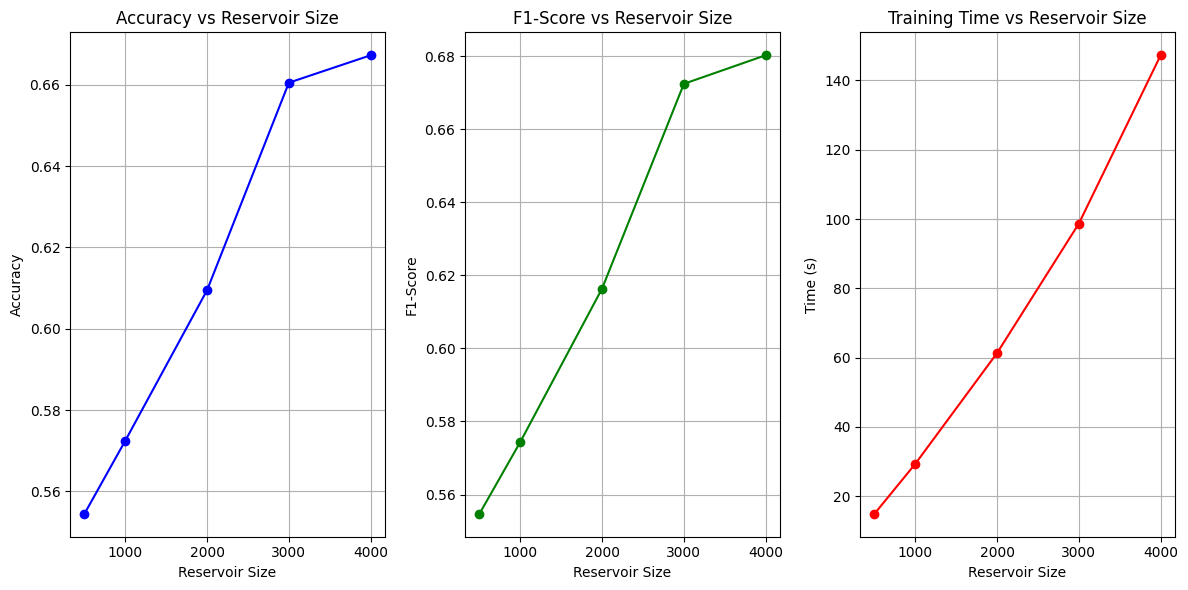

In [118]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(reservoir_sizes, accuracy_results, marker='o', color='blue')
plt.title("Accuracy vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Accuracy")
plt.grid(True)

# F1-Score Plot
plt.subplot(1, 3, 2)
plt.plot(reservoir_sizes, f1_results, marker='o', color='green')
plt.title("F1-Score vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("F1-Score")
plt.grid(True)

# Training Time Plot
plt.subplot(1, 3, 3)
plt.plot(reservoir_sizes, training_times, marker='o', color='red')
plt.title("Training Time vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

### Selected Hyperparameters

- Leak Rate = 1
- Spectral Radius = 0.9
- Input Scaling = 1.5

In [120]:
LEAK_RATE = 1             # - leaking rate
SPECTRAL_RADIUS = 0.9     # - spectral radius of W
INPUT_SCALING = 1.5       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [121]:
reservoir_sizes = [500, 1000, 2000, 3000, 4000]

# Containers to store results
accuracy_results = []
f1_results = []
training_times = []

# Loop through different reservoir sizes
for UNITS in reservoir_sizes:
    start_time = time.time()
    
    # Initialize ESN model with varying reservoir size
    data = Input(input_dim=X_train.shape[1])
    reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
    ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

    esn = data >> reservoir >> ridge

    # Train the ESN
    esn.fit(X_train, y_train)

    # Predict on test data
    predictions = esn.run(X_test)
    predicted_labels = (predictions.flatten() > 0.5).astype(int)

    # Evaluate performance
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    # Record results
    accuracy_results.append(acc)
    f1_results.append(f1)
    training_times.append(time.time() - start_time)

    print(f"Reservoir Size: {UNITS} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | Training Time: {training_times[-1]:.2f}s")


Running Model-71: 16000it [00:11, 1354.87it/s]?, ?it/s]
Running Model-71: 100%|██████████| 1/1 [00:11<00:00, 11.90s/it]


Fitting node Ridge-35...


Running Model-71: 4000it [00:02, 1445.76it/s]          


Reservoir Size: 500 | Accuracy: 0.5613 | F1-Score: 0.5603 | Training Time: 15.04s


Running Model-73: 16000it [00:22, 705.53it/s]<?, ?it/s]
Running Model-73: 100%|██████████| 1/1 [00:22<00:00, 22.96s/it]


Fitting node Ridge-36...


Running Model-73: 4000it [00:05, 706.33it/s]           


Reservoir Size: 1000 | Accuracy: 0.5773 | F1-Score: 0.5795 | Training Time: 29.23s


Running Model-75: 16000it [00:47, 335.92it/s]<?, ?it/s]
Running Model-75: 100%|██████████| 1/1 [00:48<00:00, 48.57s/it]


Fitting node Ridge-37...


Running Model-75: 4000it [00:11, 337.45it/s]           


Reservoir Size: 2000 | Accuracy: 0.6120 | F1-Score: 0.6130 | Training Time: 61.89s


Running Model-77: 16000it [01:16, 208.56it/s]<?, ?it/s]
Running Model-77: 100%|██████████| 1/1 [01:18<00:00, 78.19s/it]


Fitting node Ridge-38...


Running Model-77: 4000it [00:18, 212.66it/s]           


Reservoir Size: 3000 | Accuracy: 0.6308 | F1-Score: 0.6457 | Training Time: 103.92s


Running Model-79: 16000it [01:48, 146.81it/s]<?, ?it/s]
Running Model-79: 100%|██████████| 1/1 [01:51<00:00, 111.17s/it]


Fitting node Ridge-39...


Running Model-79: 4000it [00:26, 148.76it/s]           

Reservoir Size: 4000 | Accuracy: 0.6775 | F1-Score: 0.6895 | Training Time: 144.86s


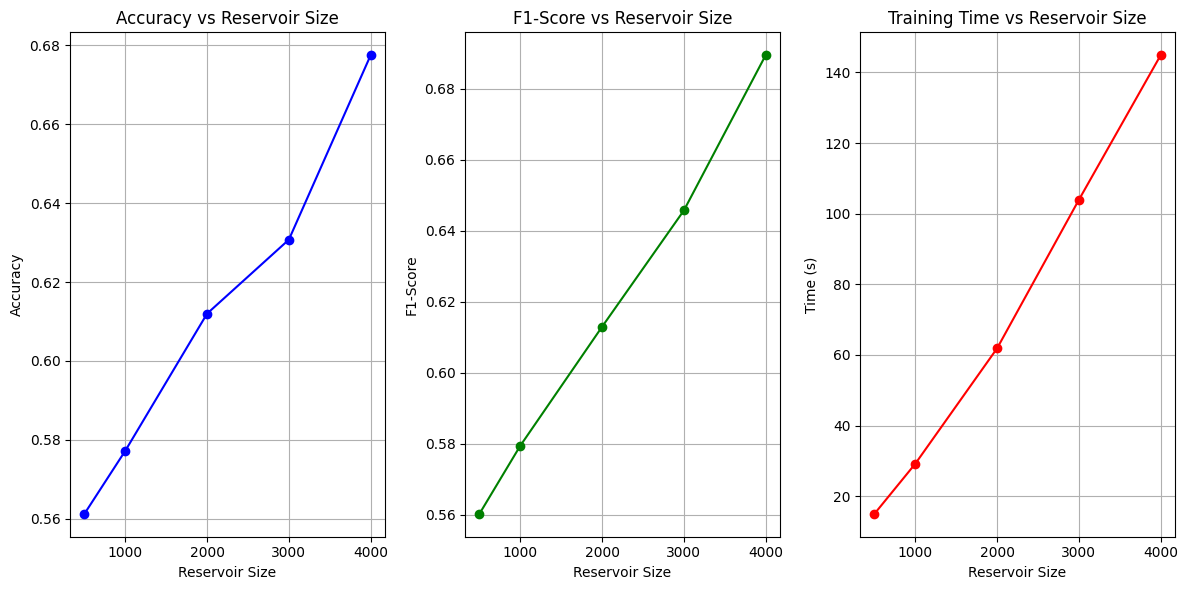

In [122]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(reservoir_sizes, accuracy_results, marker='o', color='blue')
plt.title("Accuracy vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Accuracy")
plt.grid(True)

# F1-Score Plot
plt.subplot(1, 3, 2)
plt.plot(reservoir_sizes, f1_results, marker='o', color='green')
plt.title("F1-Score vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("F1-Score")
plt.grid(True)

# Training Time Plot
plt.subplot(1, 3, 3)
plt.plot(reservoir_sizes, training_times, marker='o', color='red')
plt.title("Training Time vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

### Selected Hyperparameters

- Leak Rate = 1
- Spectral Radius = 0.9
- Input Scaling = 0.5

In [124]:
LEAK_RATE = 1             # - leaking rate
SPECTRAL_RADIUS = 0.9     # - spectral radius of W
INPUT_SCALING = 0.5       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [125]:
reservoir_sizes = [500, 1000, 2000, 3000, 4000]

# Containers to store results
accuracy_results = []
f1_results = []
training_times = []

# Loop through different reservoir sizes
for UNITS in reservoir_sizes:
    start_time = time.time()
    
    # Initialize ESN model with varying reservoir size
    data = Input(input_dim=X_train.shape[1])
    reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
    ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

    esn = data >> reservoir >> ridge

    # Train the ESN
    esn.fit(X_train, y_train)

    # Predict on test data
    predictions = esn.run(X_test)
    predicted_labels = (predictions.flatten() > 0.5).astype(int)

    # Evaluate performance
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)

    # Record results
    accuracy_results.append(acc)
    f1_results.append(f1)
    training_times.append(time.time() - start_time)

    print(f"Reservoir Size: {UNITS} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | Training Time: {training_times[-1]:.2f}s")


Running Model-81: 16000it [00:12, 1332.15it/s]?, ?it/s]
Running Model-81: 100%|██████████| 1/1 [00:12<00:00, 12.11s/it]


Fitting node Ridge-40...


Running Model-81: 4000it [00:02, 1417.83it/s]          


Reservoir Size: 500 | Accuracy: 0.5527 | F1-Score: 0.5526 | Training Time: 15.32s


Running Model-83: 16000it [00:22, 697.46it/s]<?, ?it/s]
Running Model-83: 100%|██████████| 1/1 [00:23<00:00, 23.18s/it]


Fitting node Ridge-41...


Running Model-83: 4000it [00:05, 716.80it/s]           


Reservoir Size: 1000 | Accuracy: 0.5767 | F1-Score: 0.5764 | Training Time: 29.38s


Running Model-85: 16000it [00:48, 331.98it/s]<?, ?it/s]
Running Model-85: 100%|██████████| 1/1 [00:48<00:00, 48.94s/it]


Fitting node Ridge-42...


Running Model-85: 4000it [00:11, 347.67it/s]           


Reservoir Size: 2000 | Accuracy: 0.6038 | F1-Score: 0.6044 | Training Time: 61.70s


Running Model-87: 16000it [01:14, 214.35it/s]<?, ?it/s]
Running Model-87: 100%|██████████| 1/1 [01:16<00:00, 76.19s/it]


Fitting node Ridge-43...


Running Model-87: 4000it [00:18, 217.79it/s]           


Reservoir Size: 3000 | Accuracy: 0.6260 | F1-Score: 0.6357 | Training Time: 98.98s


Running Model-89: 16000it [01:48, 147.24it/s]<?, ?it/s]
Running Model-89: 100%|██████████| 1/1 [01:51<00:00, 111.16s/it]


Fitting node Ridge-44...


Running Model-89: 4000it [00:26, 149.58it/s]           

Reservoir Size: 4000 | Accuracy: 0.6577 | F1-Score: 0.6738 | Training Time: 145.79s


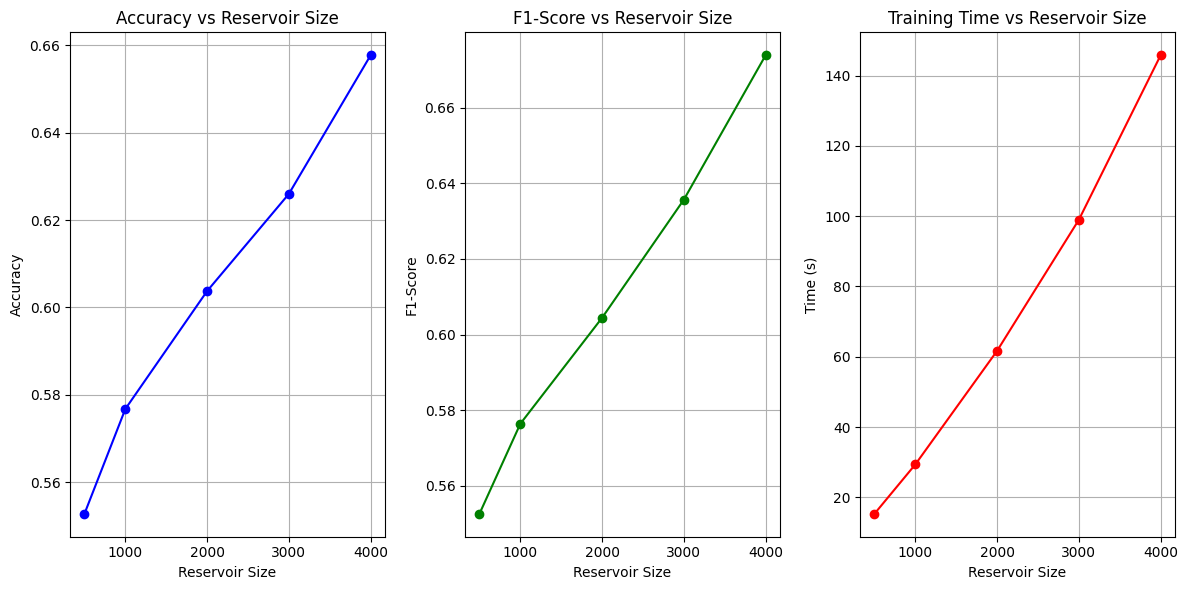

In [126]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(reservoir_sizes, accuracy_results, marker='o', color='blue')
plt.title("Accuracy vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Accuracy")
plt.grid(True)

# F1-Score Plot
plt.subplot(1, 3, 2)
plt.plot(reservoir_sizes, f1_results, marker='o', color='green')
plt.title("F1-Score vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("F1-Score")
plt.grid(True)

# Training Time Plot
plt.subplot(1, 3, 3)
plt.plot(reservoir_sizes, training_times, marker='o', color='red')
plt.title("Training Time vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [129]:
UNITS = 4000
LEAK_RATE = 1             # - leaking rate
SPECTRAL_RADIUS = 0.9     # - spectral radius of W
INPUT_SCALING = 1.5       # - input scaling
RC_CONNECTIVITY = 0.1     # - density of reservoir internal matrix
INPUT_CONNECTIVITY = 0.2  # and of reservoir input matrix
REGULARIZATION = 1e-8     # - regularization coefficient for ridge regression
SEED = 1234               # for reproductibility

In [130]:
start_time = time.time()

# Initialize ESN model with varying reservoir size
data = Input(input_dim=X_train.shape[1])
reservoir = Reservoir(UNITS, lr=LEAK_RATE, sr=SPECTRAL_RADIUS, input_scaling=INPUT_SCALING)
ridge = Ridge(output_dim=y_train.shape[1], ridge=REGULARIZATION)

esn = data >> reservoir >> ridge

# Train the ESN
esn.fit(X_train, y_train)

# Predict on test data
predictions = esn.run(X_test)
predicted_labels = (predictions.flatten() > 0.5).astype(int)

# Evaluate performance
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Record results
accuracy_results.append(acc)
f1_results.append(f1)
training_times.append(time.time() - start_time)

print(f"Reservoir Size: {UNITS} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f} | Training Time: {training_times[-1]:.2f}s")

Running Model-93: 16000it [01:51, 143.85it/s]<?, ?it/s]
Running Model-93: 100%|██████████| 1/1 [01:53<00:00, 113.79s/it]


Fitting node Ridge-46...


Running Model-93: 4000it [00:27, 144.88it/s]           

Reservoir Size: 4000 | Accuracy: 0.6753 | F1-Score: 0.6883 | Training Time: 147.93s


ValueError: x and y must have same first dimension, but have shapes (5,) and (7,)

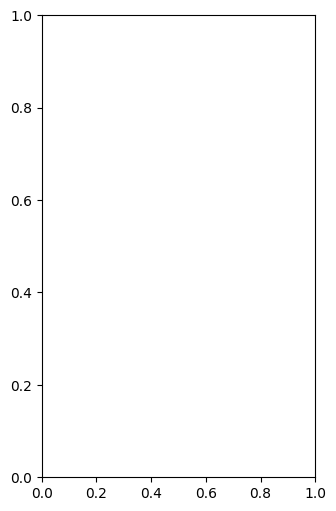

In [138]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(reservoir_sizes, accuracy_results, marker='o', color='blue')
plt.title("Accuracy vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Accuracy")
plt.grid(True)

# F1-Score Plot
plt.subplot(1, 3, 2)
plt.plot(reservoir_sizes, f1_results, marker='o', color='green')
plt.title("F1-Score vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("F1-Score")
plt.grid(True)

# Training Time Plot
plt.subplot(1, 3, 3)
plt.plot(reservoir_sizes, training_times, marker='o', color='red')
plt.title("Training Time vs Reservoir Size")
plt.xlabel("Reservoir Size")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

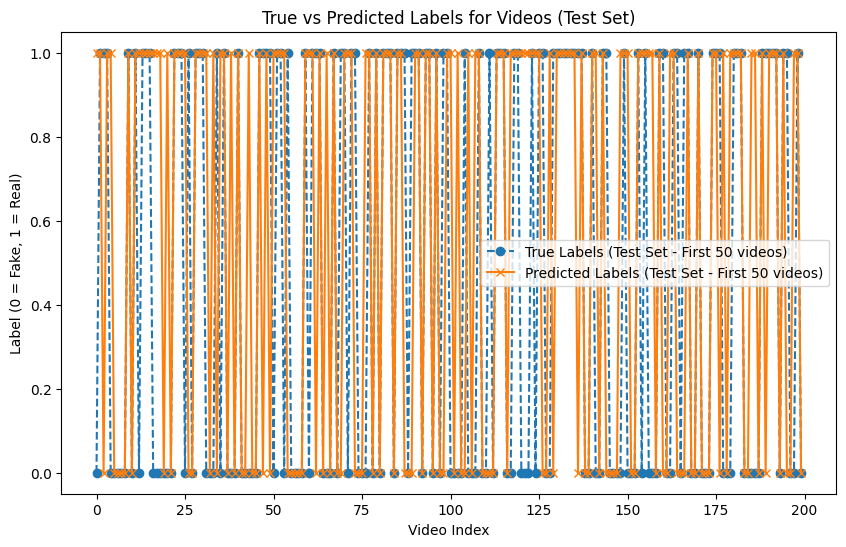

In [131]:
# Plot true vs predicted labels for a subset of the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten()[1000:1200], label='True Labels (Test Set - First 50 videos)', linestyle='--', marker='o')
plt.plot(predicted_labels[1000:1200], label='Predicted Labels (Test Set - First 50 videos)', marker='x')
plt.xlabel('Video Index')
plt.ylabel('Label (0 = Fake, 1 = Real)')
plt.legend()
plt.title('True vs Predicted Labels for Videos (Test Set)')
plt.show()

In [132]:
print(confusion_matrix(y_test, predicted_labels))
print(classification_report(y_test, predicted_labels))

[[1267  779]
 [ 520 1434]]
              precision    recall  f1-score   support

         0.0       0.71      0.62      0.66      2046
         1.0       0.65      0.73      0.69      1954

    accuracy                           0.68      4000
   macro avg       0.68      0.68      0.67      4000
weighted avg       0.68      0.68      0.67      4000



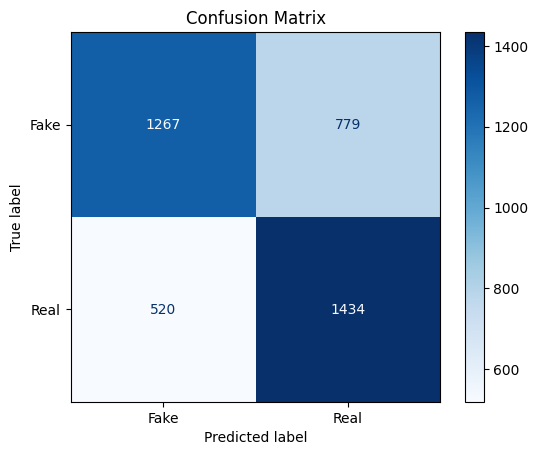

In [134]:
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

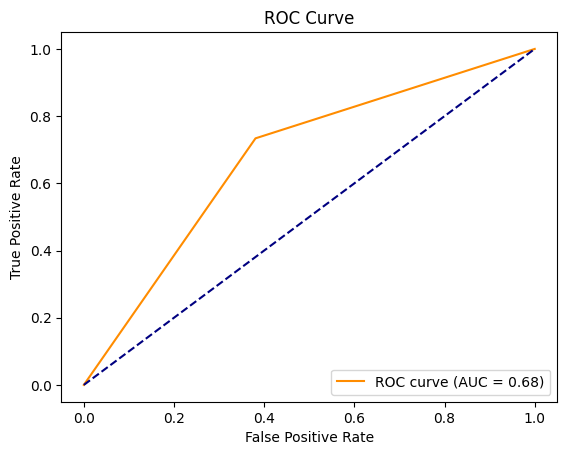

In [135]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)  # y_pred_proba are predicted probabilities
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

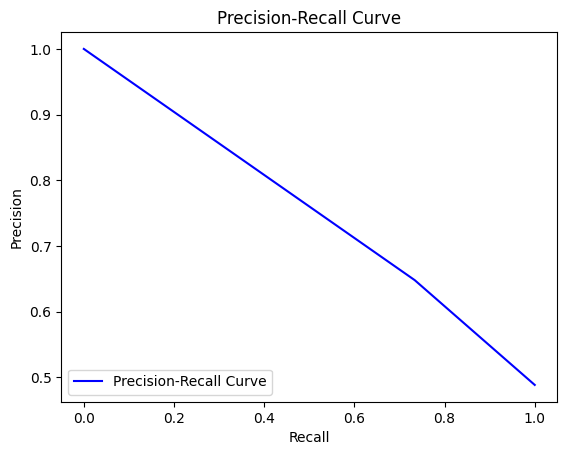

In [136]:
precision, recall, thresholds = precision_recall_curve(y_test, predicted_labels)

plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

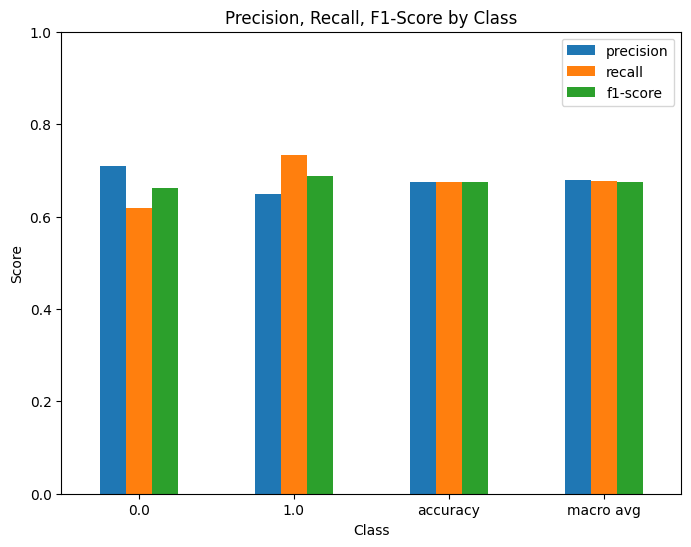

In [137]:
# Generate classification report
report = classification_report(y_test, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot Precision, Recall, F1-Score
df_report.iloc[:-1, :-1].plot(kind='bar', figsize=(8, 6))
plt.title('Precision, Recall, F1-Score by Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()
